In [1]:
!pip install xgboost imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import boto3
from io import StringIO
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset from S3
s3 = boto3.resource('s3')
bucket = 'nimbleai-whizlabs'
object_key = 'fraudTrain.csv'

csv_obj = s3.Object(bucket, object_key)
csv_string = csv_obj.get()['Body'].read().decode('utf-8')
fraud_df = pd.read_csv(StringIO(csv_string))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
Matplotlib is building the font cache; this may take a moment.


In [3]:
# Step 1: Convert date columns
fraud_df['trans_date_trans_time'] = pd.to_datetime(fraud_df['trans_date_trans_time'])
fraud_df['dob'] = pd.to_datetime(fraud_df['dob'])

# Step 2: Feature engineering
fraud_df['trans_hour'] = fraud_df['trans_date_trans_time'].dt.hour
fraud_df['trans_day_of_week'] = fraud_df['trans_date_trans_time'].dt.dayofweek + 1
fraud_df['age'] = ((fraud_df['trans_date_trans_time'] - fraud_df['dob']).dt.days / 365.25).astype(int)

# Step 3: Create age categories
custom_bins = [13, 19, 32, 42, 50, 62, float('inf')]
custom_labels = ['Teenagers', 'Young Adults', 'Adults', 'Middle-aged', 'Seniors', 'Retired']
fraud_df['age_category'] = pd.cut(fraud_df['age'], bins=custom_bins, labels=custom_labels, right=False)

# Step 4: Calculate distance to merchant
fraud_df['distance_to_merchant'] = np.sqrt(
    (fraud_df['lat'] - fraud_df['merch_lat'])**2 + (fraud_df['long'] - fraud_df['merch_long'])**2
)

# Step 5: Transactions per capita (proxy for transaction density in the city)
fraud_df['transactions_per_capita'] = fraud_df.groupby('city_pop')['trans_num'].transform('count') / fraud_df['city_pop']

# Step 6: One-hot encode categorical variables
categorical_columns = ['category', 'gender', 'age_category']
fraud_df = pd.get_dummies(fraud_df, columns=categorical_columns, drop_first=True)

In [4]:
fraud_df.head()

,Index,trans_date_trans_time,cc_num,merchant,amt,first,last,street,city,state,...,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age_category_Young Adults,age_category_Adults,age_category_Middle-aged,age_category_Seniors,age_category_Retired
0,0,2019-01-01 00:00:00,2.703190e+15,"fraud_Rippin, Kub and Mann",4.97,Jennifer,Banks,561 Perry Cove,Moravian Falls,NC,...,0,0,0,0,0,1,0,0,0,0
1,1,2019-01-01 00:00:00,6.304230e+11,"fraud_Heller, Gutmann and Zieme",107.23,Stephanie,Gill,43039 Riley Greens Suite 393,Orient,WA,...,0,0,0,0,0,0,1,0,0,0
2,2,2019-01-01 00:00:00,3.885950e+13,fraud_Lind-Buckridge,220.11,Edward,Sanchez,594 White Dale Suite 530,Malad City,ID,...,0,0,0,0,1,0,0,0,1,0
3,3,2019-01-01 00:01:00,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",45.00,Jeremy,White,9443 Cynthia Court Apt. 038,Boulder,MT,...,0,0,0,0,1,0,0,0,1,0
4,4,2019-01-01 00:03:00,3.755340e+14,fraud_Keeling-Crist,41.96,Tyler,Garcia,408 Bradley Rest,Doe Hill,VA,...,0,0,0,0,1,0,1,0,0,0


In [5]:
# Step 7: Select features dynamically
available_columns = fraud_df.columns
selected_features = [
    'amt', 'city_pop', 'trans_hour', 'trans_day_of_week', 'age',
    'distance_to_merchant', 'transactions_per_capita'
]
selected_features += [col for col in available_columns if col.startswith('category_')]
selected_features += [col for col in available_columns if col.startswith('gender_')]
selected_features += [col for col in available_columns if col.startswith('age_category_')]

X = fraud_df[selected_features]
y = fraud_df['is_fraud']

# Step 8: Scale numerical features
scaler = StandardScaler()
X[selected_features[:7]] = scaler.fit_transform(X[selected_features[:7]])

# Step 9: Apply SMOTE and K-Fold Cross-Validation
smote = SMOTE(sampling_strategy=0.2, random_state=42, k_neighbors=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)



/tmp/ipykernel_8273/667325941.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[selected_features[:7]] = scaler.fit_transform(X[selected_features[:7]])


In [7]:
fraud_df.shape

(1048575, 45)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:50:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1: AUC = 0.9961, F1 = 0.8626, Precision = 0.9253, Recall = 0.8078


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:50:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2: AUC = 0.9978, F1 = 0.8623, Precision = 0.9167, Recall = 0.8140


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:50:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3: AUC = 0.9978, F1 = 0.8549, Precision = 0.9200, Recall = 0.7983


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:51:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4: AUC = 0.9967, F1 = 0.8552, Precision = 0.9035, Recall = 0.8118


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:51:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5: AUC = 0.9976, F1 = 0.8664, Precision = 0.9173, Recall = 0.8209

Final Metrics:
Mean AUC: 0.9972 ± 0.0007
Mean F1: 0.8603 ± 0.0045
Mean Precision: 0.9166 ± 0.0072
Mean Recall: 0.8105 ± 0.0074


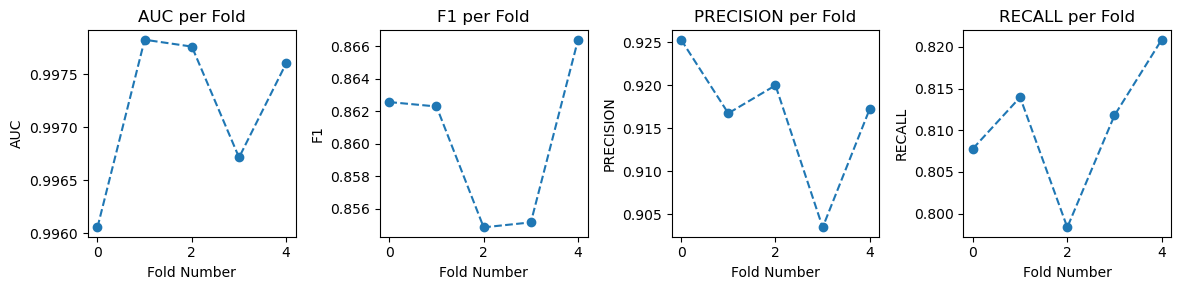

In [8]:
metrics = {'auc': [], 'f1': [], 'precision': [], 'recall': []}

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    X_res, y_res = smote.fit_resample(X_train, y_train)

    class_ratio = (y_res == 0).sum() / (y_res == 1).sum()

    model = XGBClassifier(
        objective='binary:logistic',
        n_estimators=300,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.2,
        reg_lambda=0.2,
        scale_pos_weight=class_ratio,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    model.fit(X_res, y_res)

    probas = model.predict_proba(X_valid)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_valid, probas)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]

    preds = (probas >= best_threshold).astype(int)

    metrics['auc'].append(roc_auc_score(y_valid, probas))
    metrics['f1'].append(f1_score(y_valid, preds))
    metrics['precision'].append(precision_score(y_valid, preds))
    metrics['recall'].append(recall_score(y_valid, preds))

    print(f"Fold {fold}: AUC = {metrics['auc'][-1]:.4f}, F1 = {metrics['f1'][-1]:.4f}, "
          f"Precision = {metrics['precision'][-1]:.4f}, Recall = {metrics['recall'][-1]:.4f}")

# Print final results
print("\nFinal Metrics:")
print(f"Mean AUC: {np.mean(metrics['auc']):.4f} ± {np.std(metrics['auc']):.4f}")
print(f"Mean F1: {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
print(f"Mean Precision: {np.mean(metrics['precision']):.4f} ± {np.std(metrics['precision']):.4f}")
print(f"Mean Recall: {np.mean(metrics['recall']):.4f} ± {np.std(metrics['recall']):.4f}")

# Step 10: Plot metrics
plt.figure(figsize=(12, 3))
for i, metric in enumerate(metrics.keys(), 1):
    plt.subplot(1, 4, i)
    plt.plot(metrics[metric], marker='o', linestyle='--')
    plt.title(f'{metric.upper()} per Fold')
    plt.xlabel('Fold Number')
    plt.ylabel(metric.upper())
plt.tight_layout()
plt.show()

In [9]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 45 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Index                      1048575 non-null  int64         
 1   trans_date_trans_time      1048575 non-null  datetime64[ns]
 2   cc_num                     1048575 non-null  float64       
 3   merchant                   1048575 non-null  object        
 4   amt                        1048575 non-null  float64       
 5   first                      1048575 non-null  object        
 6   last                       1048575 non-null  object        
 7   street                     1048575 non-null  object        
 8   city                       1048575 non-null  object        
 9   state                      1048575 non-null  object        
 10  zip                        1048575 non-null  int64         
 11  lat                        1048575 no